# Brainstorming

**Goal:** I'm just trying to sort through why the accuracies are *lower* on the test set in `pairAGraphEx.ipynb`.

It seems like this *might* be due to some issues in my `preprocess.transformData` function - but this notebook is to try to sort this out!!

In [1]:
import pandas as pd
import numpy as np
import torch
import json

import matplotlib.pyplot as plt

from preprocess import getNumPairs, scale, transformData, prepareData, jetVars, applyCuts
from trainNet import getGNNDataLoaders, pairAGraph, check_accuracy
from GNNPlots import trainingMetrics

from preprocess import getHCs, applyCuts, getHelicityAngles
from uproot_methods.classes.TLorentzVector import TLorentzVectorArray

import os
os.sys.path.append('../code')
from analysis import normalizeWeight

# The lines below let you edit codes in modules and update the function definitions
# in your notebook automatically without having to load them in again.
%load_ext autoreload
%autoreload 2

In [2]:
physicsSample = 'SMNR'
nSelectedJets = 5
prodTag = 'MAR2020'

**Plan:** Look at the distribution of `logits` that get outputted by `model`

In [3]:
subDir = f'{physicsSample}_mc16a_PFlow-{prodTag}-{nSelectedJets}jets'

df = pd.read_hdf(f"../data/{subDir}/df_3b_scaledInputs.h5", key='df')
#df = df[df.index % 2 == 0]

In [5]:
X_test = np.dstack([df[['ml_j{}_{}'.format(i,v) for i in range(nSelectedJets)]].values for v in jetVars])
njets = np.sum(~ np.all(X_test==0, axis=-1),axis=1) 

ttlPairs = getNumPairs(nSelectedJets)
scoreMask = np.ones((X_test.shape[0],ttlPairs)).astype(bool)

for ji in range(4,nSelectedJets):
    nPairs = getNumPairs(ji)
    scoreMask[njets==ji] *= np.array([True]*nPairs + [False]*(ttlPairs-nPairs))

X_test = torch.tensor(X_test).float()#.to(device)
scoreMask = torch.tensor(scoreMask)

In [6]:
GNNParams= {'physicsSample': 'SMNR',
            'mc': 'mc16ade',
            'prodTag': 'MAR2020',
            'nSelectedJets': 5,
            'nLayers': 1,
            'embed_dim': 20, 
            'ff_dim': 20,
            'nHeads': 4,
            'dpt': 0.3,
            'lr': 0.01,
            'epoch': 17}

nLayers, embed_dim, ff_dim = GNNParams['nLayers'], GNNParams['embed_dim'], GNNParams['ff_dim']
nHeads, dpt, lr, epoch = GNNParams['nHeads'], GNNParams['dpt'], GNNParams['lr'], GNNParams['epoch']

# Load in the model
model = pairAGraph(inpt_dim=len(jetVars),embed_dim=embed_dim,ff_dim=ff_dim,
                   nAttnBlocks=1,nHeads=nHeads,p=dpt,njets=nSelectedJets)

In [7]:
xformerDir = f'xformer_{nLayers}layers_dim{embed_dim}_ff{ff_dim}_{nHeads}heads_dpt{dpt}_jetCompatibility_lr{lr}_batch2048'
modelDir = f"models/{physicsSample}_mc16ade_PFlow-{prodTag}-{nSelectedJets}jets/{xformerDir}"
model.load_state_dict(torch.load(f'{modelDir}/model_epoch17.pt',map_location='cpu'))
model.eval()

pairAGraph(
  (toLatent): Linear(in_features=5, out_features=20, bias=True)
  (encoderLayer1): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): Linear(in_features=20, out_features=20, bias=True)
    )
    (linear1): Linear(in_features=20, out_features=20, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
    (linear2): Linear(in_features=20, out_features=20, bias=True)
    (norm1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.3, inplace=False)
    (dropout2): Dropout(p=0.3, inplace=False)
  )
  (finalAttnLayer): MultiheadAttention(
    (out_proj): Linear(in_features=20, out_features=20, bias=True)
  )
)

In [53]:
float('-inf')

-inf

In [ ]:
logits[~scoreMask] = 

In [8]:
logits, _ = model(X_test)

In [9]:
logits = logits.detach().numpy()

In [ ]:
np.sum(njets==4)

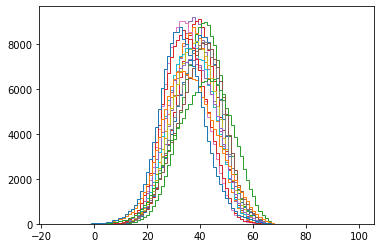

In [10]:
plt.hist(logits[njets==4],100,(-15,100),histtype='step')
plt.show()

Ok - this is a little hard to read b/c the logits are all over the board, but for 4-jet events, I only look at the first 3 pairs any ways.

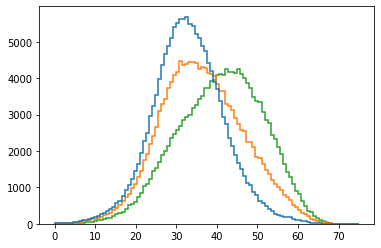

In [19]:
nb,r = 100, (0,75)
plt.hist(logits[njets==4,:3],nb,r,histtype='step',linewidth=1.5)
plt.show()

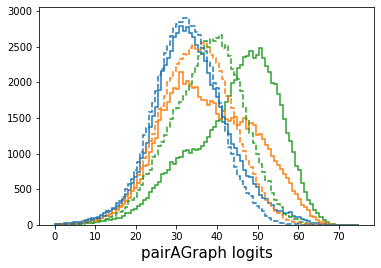

In [23]:
cs = [f'C{i}' for i in range(3)]
plt.hist(logits[(njets==4)&(df.correctPair==df.predPair),:3],nb,r,histtype='step',color=cs,linewidth=1.5)
plt.hist(logits[(njets==4)&(df.correctPair!=df.predPair),:3],nb,r,histtype='step',linestyle='--',color=cs,linewidth=1.5)

plt.xlabel('pairAGraph logits',fontsize=15)
plt.show()

Ok - so this plot is a little hard to read - but it's already kind of cool that there's more separation between the pairs for the cases where I get the correct pair, no?

**For events where we predicted the correct pair, show the correct pair in solid and the other pairs in dashed lines**

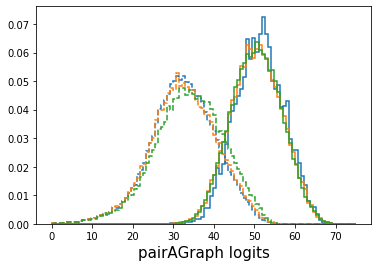

In [41]:
for i in range(3):
    plt.hist(logits[(njets==4)&(df.correctPair==df.predPair)&(df.predPair==i),i],nb,r,histtype='step',
             color=f'C{i}',linewidth=1.5,density=True)
    plt.hist(logits[(njets==4)&(df.correctPair==df.predPair)&(df.predPair!=i),i],nb,r,histtype='step',
             color=f'C{i}',linestyle='--',linewidth=1.5,density=True)
    #plt.hist(logits[(njets==4)&(df.correctPair!=df.predPair),:3],nb,r,histtype='step',linestyle='--',color=cs,linewidth=1.5)

plt.xlabel('pairAGraph logits',fontsize=15)
plt.show()

So the plot only includes events where I got the correct pair, and shows the distiribution of the chosen vs not chosen logits.

**Lesson:** It seems sensible!

Of course, to understand how the model is suboptimal, I should be digging into the dashed lines (where pairAGraph  made the *wrong* prediction) - but maybe also for events where the correct pair existed?

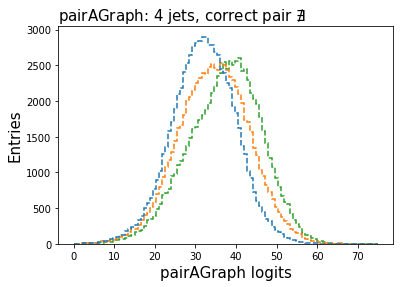

In [30]:
cs = [f'C{i}' for i in range(3)]
plt.hist(logits[(njets==4)&(df.correctPair!=df.predPair)&(df.correctPair==-1),:3],nb,r,
         histtype='step',linestyle='--',color=cs,linewidth=1.5)

plt.xlabel('pairAGraph logits',fontsize=15)
plt.ylabel('Entries',fontsize=15)
plt.title(r'pairAGraph: 4 jets, correct pair $\nexists$',loc='left',fontsize=15)
plt.show()

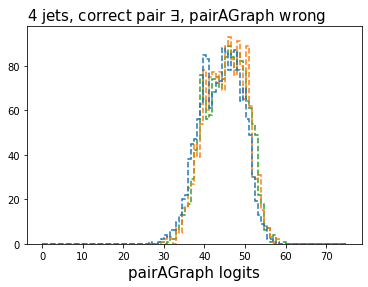

In [32]:
plt.hist(logits[(njets==4)&(df.correctPair!=df.predPair)&(df.correctPair!=-1),:3],nb,r,histtype='step',linestyle='--',color=cs,linewidth=1.5)

plt.xlabel('pairAGraph logits',fontsize=15)
plt.title(r'4 jets, correct pair $\exists$, pairAGraph wrong',loc='left',fontsize=15)
plt.show()

In [44]:
df.predPair

entry
0          2
2          5
7          1
13        14
14        12
          ..
777142     1
777144     2
777145     1
777146     2
777149     2
Name: predPair, Length: 323069, dtype: int64

Is this interesting, for the failure 4-jet cases?

I guess this is good if when it's wrong, it's predicting the same distributions...

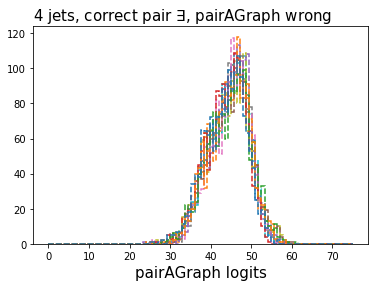

In [34]:
plt.hist(logits[(njets==4)&(df.correctPair!=df.predPair)&(df.correctPair!=-1),3:],nb,r,histtype='step',linestyle='--',linewidth=1.5)

plt.xlabel('pairAGraph logits',fontsize=15)
plt.title(r'4 jets, correct pair $\exists$, pairAGraph wrong',loc='left',fontsize=15)
plt.show()

In [35]:
plt.hist(logits[(njets==4)&(df.correctPair!=df.predPair)&(df.correctPair!=-1)],nb,r,histtype='step',linestyle='--',linewidth=1.5)

plt.xlabel('pairAGraph logits',fontsize=15)
plt.title(r'4 jets, correct pair $\exists$, pairAGraph wrong',loc='left',fontsize=15)
plt.show()

Ok - the *biggest take away* (I guess?) that I'm getting from this is that the logits are normally positive - so the issue of setting the non-relevant logits to 0 probably wasn't really hurting my scoring pred, although if my loss function inclues a softmax, maybe I would want to use -15 instead...

In [42]:
df[(df.correctPair!=df.predPair)& (df.correctPair!=-1)].head()

eventNumber  nresolvedJets  ...      Phi1          HT
entry                               ...                      
81             1456              6  ...  3.121124  524.958084
161             138              6  ... -1.372053  258.119350
263            1479              4  ...  2.230142  240.313107
510            1785              8  ...  1.231072  250.842270
842             856              6  ... -1.240600  265.239799
...             ...            ...  ...       ...         ...
776385       484927              6  ... -2.270925  353.944187
776601       484969              6  ... -2.890732  314.043629
776735       484811              6  ... -2.559894  257.676205
776948       484173              5  ... -1.554260  314.776314
777083       473677              7  ... -1.552019  553.474815

[10018 rows x 161 columns]

Text(0.5, 0, 'predPair')

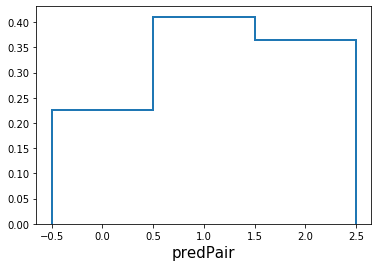

In [51]:
m = (df.correctPair!=df.predPair)& (df.correctPair!=-1)&(df.njets==4)
plt.hist(df.loc[m,'predPair'],3,(-0.5,2.5),weights=df.loc[m,'mc_sf'],histtype='step',density=True,linewidth=2)
plt.xlabel('predPair',fontsize=15)

In [52]:
plt.hist(df.loc[m,'correctPair'],3,(-0.5,2.5),weights=df.loc[m,'mc_sf'],histtype='step',density=True,linewidth=2)
plt.xlabel('correctPair',fontsize=15)

Text(0.5, 0, 'correctPair')

Hmmmm - it seem interesting that it's mostly missing the events w/ truth label 2, when these are also the *most* likely...

Ok - this is *consistent* with some of the preprocessing that I was doing that was suggessting that most of the time the correct pair corresponds to pairing the leading and trailing $b$-quarks together.

Hmmmm - idk *why* there's this distribution over logits for the 4-jet events, and it kind of makes me think that maybe the masking in pairAGraph isn't working properly?

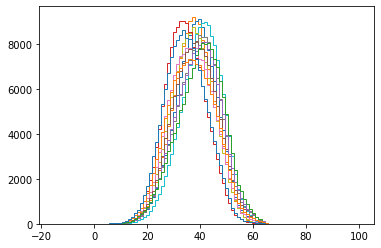

In [71]:
plt.hist(logits[njets==4,3:],100,(-15,100),histtype='step')
plt.show()

In [69]:
logits[njets==4].shape

(153815, 15)

In [ ]:
plt.hist(logits[njets==4],100,(-15,100))
plt.show()

In [66]:
plt.hist(logits[njets==5],100,(-15,100))
plt.show()

In [6]:
# df = pd.read_hdf(f"../data/{subDir}/df_3b_scaledInputs.h5", key='df')
# df = df[df.index % 2 == 0]

# # Since I'm only using half the stats for the test set, need to multiply L by 2.
# L = 24.5556
# key = f'{physicsSample}_mc16a_PFlow-{prodTag}'
# print(key)
# normalizeWeight(df,key,lumi=L*2)

In [12]:
applyCuts(df,model,nSelectedJets)

Getting jet pts
Getting jet etas
Getting jet phis
Getting jet Es
Calculating Xwt
Calculating Xhh
